# Regularization and regression

In this notebook, it is presented a complete approach of phone price, using the kaggle's dataset.

`https://www.kaggle.com/code/awojidemargaret/phone-price-classification/data`

### Objectives

* Implement data standarization
* Implement variants of regularized regression and compare its with classic regression
* Combine cross validation and grid search for validate models
* Make conclusions about data

In [49]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)


## Loading dataset

**Note:** Price_Range_Test.csv belongs to target variable in test.csv 

In [2]:
#Load train
train = pd.read_csv('train.csv')

#Load test
test = pd.read_csv('test.csv')
test_y = pd.read_csv('Price_Range_Test.csv')
test = test.merge(test_y, how='inner',left_on='id', right_on='id')
test = test.drop('id',axis=1)


### Integrity validation

In [3]:
train.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [4]:
train.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

Data does not contain any nulls

Text(0.5, 1.0, 'Sales correlation')

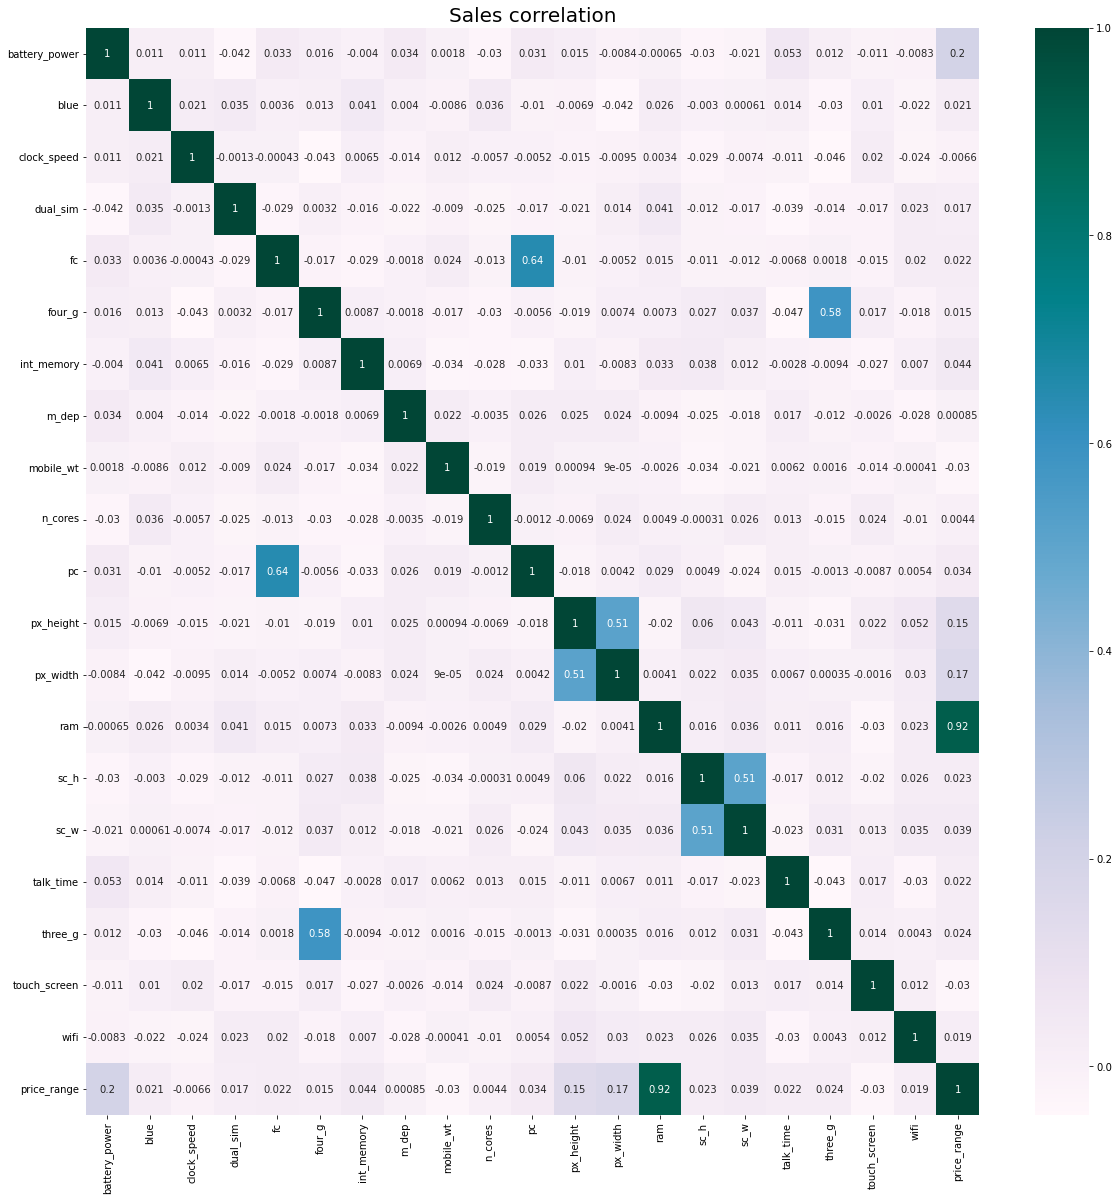

In [7]:
plt.figure(figsize=(20,20))
hm=sns.heatmap(train.corr(),cmap="PuBuGn",annot=True)
hm.set_title('Sales correlation', fontdict={'fontsize':20})

Exist a strong correlation between `ram` and `price range`

# Data standarization

**Generate X and y**

In [8]:
target = 'price_range'

X_train = train.drop(target,axis=1)
y_train = train[target]

X_test = test.drop(target,axis=1)
y_test = test[target]


**Import, fit, and transform using `StandardScaler`**

In [9]:
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

# Regression

**Linear Regression**

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9208916914919806

In [15]:
pd.DataFrame(zip(X_train.columns, np.abs(lr.coef_))).sort_values(by=1,ascending=False)

,0,1
13,ram,1.027189
0,battery_power,0.223851
11,px_height,0.122691
12,px_width,0.120805
8,mobile_wt,0.031148
6,int_memory,0.015686
3,dual_sim,0.011853
17,three_g,0.011527
19,wifi,0.010722
2,clock_speed,0.009840


Looking just at the strength of the standardized coefficients `ram` is the most impactful variable. `battery_power` show a moderated impact

**Ridge Regression**

In [68]:
alphas = [0.0001,0.001,0.01,0.1,0.07,1,1.1,1.4]

ridgeCV = RidgeCV(alphas=alphas,cv=10)
ridgeCV.fit(X_train,y_train)
print("best alpha:", ridgeCV.alpha_)
print("best score",ridgeCV.score(X_test, y_test))

best alpha: 1.4
best score 0.9208779689839375


In [69]:
pd.DataFrame(zip(X_train.columns, np.abs(ridgeCV.coef_))).sort_values(by=1,ascending=False)

,0,1
13,ram,1.026463
0,battery_power,0.223694
11,px_height,0.122615
12,px_width,0.120759
8,mobile_wt,0.031127
6,int_memory,0.015699
3,dual_sim,0.011822
17,three_g,0.011527
19,wifi,0.010694
2,clock_speed,0.009829


Ridge regression not show any significative differente vs classic linear regression

In [71]:
print('Number of coeffients equal to 0 for Lasso:', (ridgeCV.coef_==0).sum(), ' of ', len(ridgeCV.coef_))

Number of coeffients equal to 0 for Lasso: 0  of  20


No variables was ignored in ridge Regression

**Lasso Regresion**

In [60]:
alphas = [0.0001,0.001,0.002,0.005,0.01,0.1,1]

lassoCV = LassoCV(alphas=alphas,max_iter=5000, cv=10)
lassoCV.fit(X_train,y_train)
print("best alpha:",lassoCV.alpha_)
print("best score",lassoCV.score(X_test, y_test))

best alpha: 0.005
best score 0.921639781986


In [62]:
pd.DataFrame(zip(X_train.columns, np.abs(lassoCV.coef_))).sort_values(by=1,ascending=False)

,0,1
13,ram,1.022288
0,battery_power,0.219022
11,px_height,0.119113
12,px_width,0.117510
8,mobile_wt,0.026410
6,int_memory,0.010856
3,dual_sim,0.007380
17,three_g,0.006221
2,clock_speed,0.005168
19,wifi,0.005153


In [70]:
print('Number of coeffients equal to 0 for Lasso:', (lassoCV.coef_==0).sum(), ' of ', len(lassoCV.coef_))

Number of coeffients equal to 0 for Lasso: 10  of  20


10 Variables was omited in Lasso, increasing the performance and reduce complexity of the model

In [79]:
porcentual_coef =np.abs(lassoCV.coef_)*100/np.sum(np.abs(lassoCV.coef_))
pd.DataFrame(zip(X_train.columns, np.abs(porcentual_coef))).sort_values(by=1,ascending=False).head(7)

,0,1
13,ram,66.420267
0,battery_power,14.230341
11,px_height,7.739006
12,px_width,7.634872
8,mobile_wt,1.715913
6,int_memory,0.705357
3,dual_sim,0.479488


The `Lasso Regression` is best model with a accuracy of `92.16%`. A percentage analysis of the coefficients show that `ram` (Random access memory) It is by far the factor that most affects the price of a cell phone. The `battery_power`,  `px_height` and `px_width` are factors that affect the price of the cell phone between slightly and moderately.